In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
np.random.seed(123456)
import math as m
from scipy import stats
from scipy.stats import norm
import pandas as pd
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Integral obtained with guassians: 499.9999971290034
Normalization of integral obtained with guassians: 229.2767694396335
Integral of original histogram: 229.27677075613917


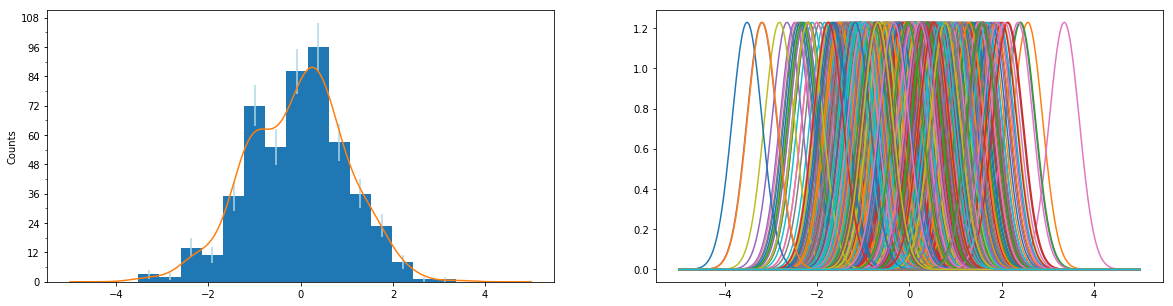

In [2]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

#array x
x = np.random.normal(0,1,500)

#filling the histogram 
n, bins, _ = ax1.hist(x,15)

#y label
ax1.set_ylabel('Counts')

#set tick
majorLocator = MultipleLocator(12)
minorLocator = MultipleLocator(6)
ax1.yaxis.set_major_locator(majorLocator)
ax1.yaxis.set_minor_locator(minorLocator)

#data points
dp = np.array([[(bins[i-1]+bins[i])/2 for i in range(1,len(bins))],n,[m.sqrt(n[i]) for i in range(len(n))]])
ax1.errorbar(dp[0,:],dp[1,:],dp[2,:],fmt='none',ecolor='lightblue')

#gaussians
std = 1.06*x.std()*x.size**(-1./5.)

X=np.linspace(-5, 5, num=500)
Xpdf=[]

for i in range(len(x)):
    mean = x[i]
    Xpdf.append(norm.pdf(X,mean,std))
    ax2.plot(X, Xpdf[i], '-')

#sum the gaussian
Xpdf=np.array(Xpdf)
pdf=np.sum(Xpdf, axis=0)

#bin width
bin_width=bins[1]-bins[0]
#integral of original histogram
int_origin=np.sum(n*bin_width)

#calculate the integral
int_gauss=np.trapz(pdf, X)

#plot the sum of gaussian
ax1.plot(X, pdf*bin_width,'-')


print("Integral obtained with guassians:", int_gauss)
print("Normalization of integral obtained with guassians:", int_gauss*bin_width)
print("Integral of original histogram:", int_origin)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

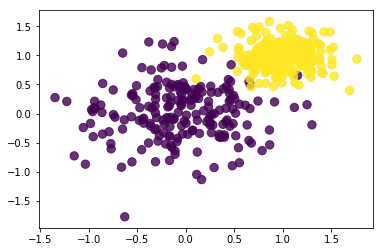

In [3]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [4]:
def category2D(means, stds):
    x = norm.rvs(means[0],stds[0],100)
    y = norm.rvs(means[1],stds[1],100)
    return np.array([x,y])

In [5]:
def dataset2D(mean, std): 
    return np.array([category2D(mean[0,:],std[0,:]),category2D(mean[1,:],std[1,:])])

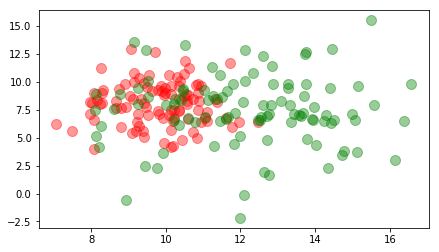

In [6]:
fig,ax = plt.subplots(figsize=(7,4))

#generate and plot the data
mean=np.array([[10,8],[12,7]])
std=np.array([[1,2],[2,3]])
data = dataset2D(mean,std)
ax.plot(data[0,0,:],data[0,1,:], 'ro',markersize=10, alpha=0.4)
ax.plot(data[1,0,:],data[1,1,:], 'go',markersize=10, alpha=0.4)

In [7]:
#n>2 categories
#function categories2 already defined

def ncategories(n, mean, std):
    categories=[]
    for i in range(n):
        categories.append(category2D(mean[i,:], std[i,:]))
    return np.array(categories)

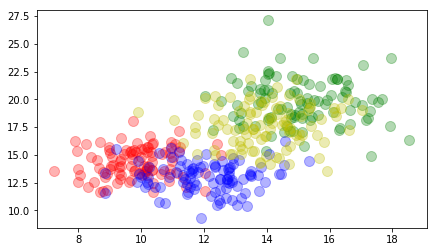

In [8]:
#n=4
fig,ax = plt.subplots(figsize=(7,4))

#generate and plot the data
mean=np.array([[10,14],[15,20],[12,13],[14,18]])
std=np.array([[1,1.4],[1.5,2],[1.2,1.3],[1.4,1.8]])
data = ncategories(4,mean,std)
ax.plot(data[0,0,:],data[0,1,:], 'ro',markersize=10, alpha=0.3)
ax.plot(data[1,0,:],data[1,1,:], 'go',markersize=10, alpha=0.3)
ax.plot(data[2,0,:],data[2,1,:], 'bo',markersize=10, alpha=0.3)
ax.plot(data[3,0,:],data[3,1,:], 'yo',markersize=10, alpha=0.3)


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [9]:
#load file
file_name = "residuals_261.npy"
dataset = dict(np.load(file_name).item())

#creation of DataFrame
dataset = pd.DataFrame(dataset)
dataset.T

,0,1,2,3,4,5,6,7,8,9,...,11121,11122,11123,11124,11125,11126,11127,11128,11129,11130
residuals,1.1,-1.95,-7.2,-4.15,-6.59,-11.02,-2.27,-2.16,-0.042857,0.128571,...,-4.38,-1.77,-2.64,-1.52,-2.66,-0.76,0.38,0.083333,0.166667,0.083333
distances,16.0,6.30,3.4,8.40,1.70,4.40,0.60,19.00,3.300000,5.300000,...,9.60,1.60,4.60,16.20,1.90,14.40,7.50,1.700000,19.100000,2.600000


In [10]:
#cleaning
cleand=dataset[np.absolute(dataset['residuals']) < 2]
cleand.T

,0,1,8,9,10,11,12,13,14,15,...,11117,11118,11119,11122,11124,11126,11127,11128,11129,11130
residuals,1.1,-1.95,-0.042857,0.128571,0.085714,-0.13,-0.09,0.21,0.17,0.042857,...,0.34,-0.16,-0.22,-1.77,-1.52,-0.76,0.38,0.083333,0.166667,0.083333
distances,16.0,6.30,3.300000,5.300000,15.000000,9.30,10.20,12.20,7.90,4.500000,...,6.00,15.80,4.20,1.60,16.20,14.40,7.50,1.700000,19.100000,2.600000


In [11]:
#regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cleand['distances'], cleand['residuals'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


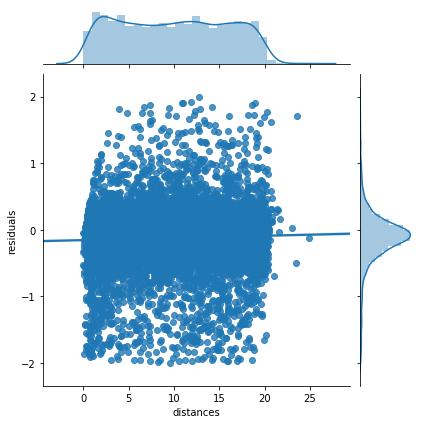

In [12]:
#plot with sns
sns.jointplot(x="distances", y="residuals", data=cleand, kind='reg')

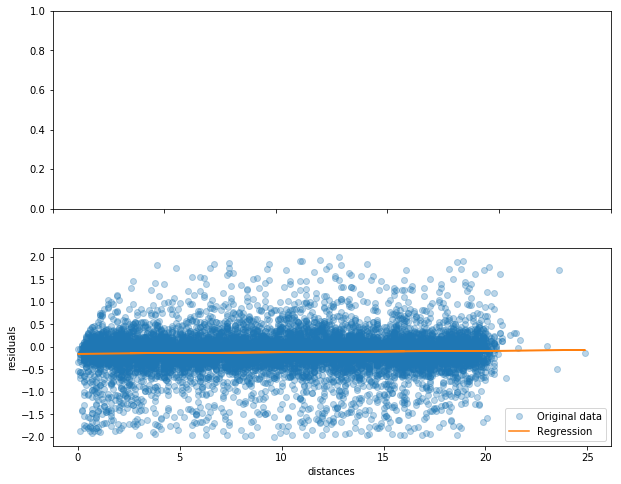

In [13]:
#hist:
bins=8



#plot with linregress->profile plot
fig,(ax1,ax2)= plt.subplots(nrows=2, ncols=1,figsize=(10, 8))

ax1.tick_params(axis='x',which='both',labelbottom=False)

ax2.set_xlabel('distances')
ax2.set_ylabel('residuals')
ax2.plot(cleand['distances'],cleand['residuals'], 'o',alpha=0.3, label='Original data')
ax2.plot(cleand['distances'],cleand['distances']*slope+intercept,label='Regression')
ax2.legend()